# Face Mask Detection model to discern whether an individual is wearing a mask correctly or not at all.

The dataset contains 3 folders labeled as to which class they belong to. The 3 classes
are "with_mask", "without_mask", and "mask_weared_incorrect". Each folder holds 2994 images
of people that belong to such a labeled class: https://www.kaggle.com/datasets/vijaykumar1799/face-mask-detection



In [ ]:
from google.colab import files

# Upload the "kaggle.json" file downloaded from Kaggle
uploaded = files.upload()

Saving kaggle.json to kaggle.json


## Getting the data and extracting it

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vijaykumar1799/face-mask-detection

 87% 193M/222M [00:01<00:00, 120MB/s]
100% 222M/222M [00:01<00:00, 167MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/face-mask-detection.zip")
zip_ref.extractall()
zip_ref.close()


In [ ]:
import os

!mkdir data
!mkdir data/train
!mkdir data/train/mask_weared_incorrect
!mkdir data/train/with_mask
!mkdir data/train/without_mask

!mkdir data/test
!mkdir data/test/mask_weared_incorrect
!mkdir data/test/with_mask
!mkdir data/test/without_mask

## Preprocessing and Visualizing the data

In [ ]:
# Creating train and test dataset

import shutil

path = "/content/data/"

# Train dataset
for filename in os.listdir("/content/Dataset/with_mask")[0:2400]:
    src_path = "/content/Dataset/with_mask/" + filename
    dst_path = os.path.join(path, 'train/with_mask/')
    shutil.move(src_path, dst_path)

for filename in os.listdir("/content/Dataset/without_mask")[0:2400]:
    src_path = '/content/Dataset/without_mask/' + filename
    dst_path = os.path.join(path, 'train/without_mask/')
    shutil.move(src_path, dst_path)

for filename in os.listdir("/content/Dataset/mask_weared_incorrect")[0:2400]:
    src_path = '/content/Dataset/mask_weared_incorrect/' + filename
    dst_path = os.path.join(path, 'train/mask_weared_incorrect')
    shutil.move(src_path, dst_path)

# move rest of the files to the test directory
for filename in os.listdir("/content/Dataset/with_mask"):
    src_path = "/content/Dataset/with_mask/" + filename
    dst_path = os.path.join(path, 'test/with_mask/')
    shutil.move(src_path, dst_path)

for filename in os.listdir("/content/Dataset/without_mask"):
    src_path = '/content/Dataset/without_mask/' + filename
    dst_path = os.path.join(path, 'test/without_mask/')
    shutil.move(src_path, dst_path)

for filename in os.listdir("/content/Dataset/mask_weared_incorrect"):
    src_path = '/content/Dataset/mask_weared_incorrect/' + filename
    dst_path = os.path.join(path, 'test/mask_weared_incorrect')
    shutil.move(src_path, dst_path)

In [ ]:
# Getting the classnames

import numpy as np
import pathlib

train_dir = "/content/data/train"
test_dir = "/content/data/test"

data_dir = pathlib.Path(train_dir)

class_name = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_name

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype='<U21')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


dir = "/content/data/train"

def view_images(directory=dir, class_name="with_mask", NOI=5):
    '''
      This function shows random images given the directory=dir,
      class_name="with_mask", NOI=5.
    '''
    filedir = os.path.join(directory, class_name)  # Use os.path.join to create the file path

    random_img = random.sample(os.listdir(filedir), NOI)

    plt.figure(figsize=(15, 5))

    for i, filename in enumerate(random_img):  # Use enumerate to get both index and filename
        path = os.path.join(filedir, filename)  # Create the full path to the image
        plt.subplot(NOI // 5, 5, i+1)  # Adjust subplot layout
        img = mpimg.imread(path)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

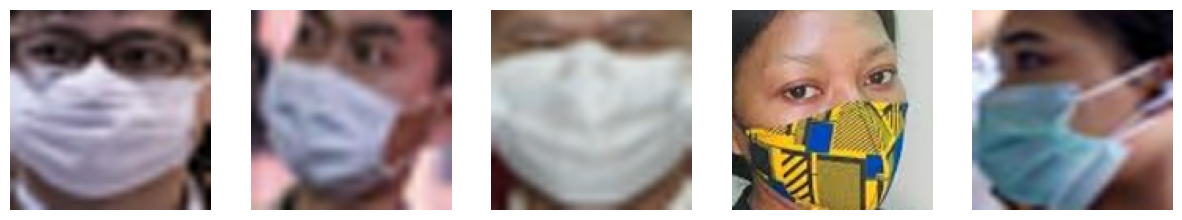

In [ ]:
view_images(NOI=10)

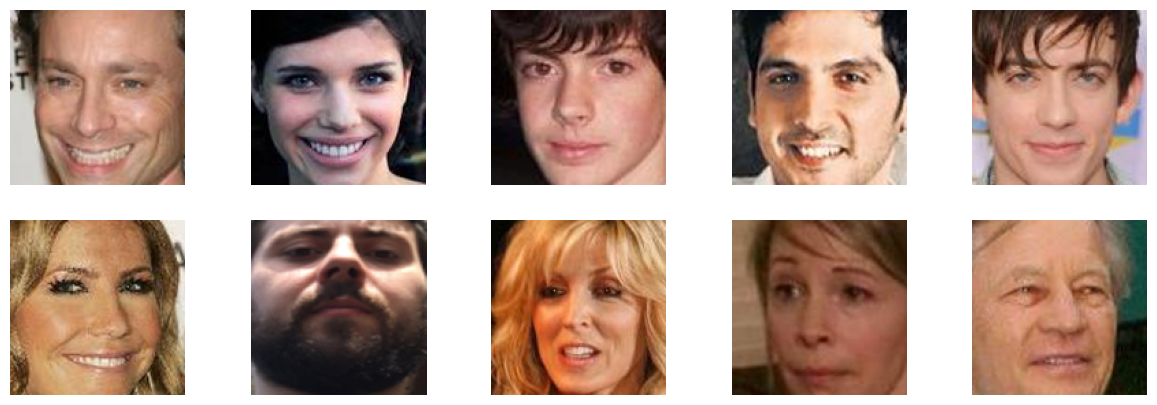

In [ ]:
view_images(class_name="without_mask", NOI=10)

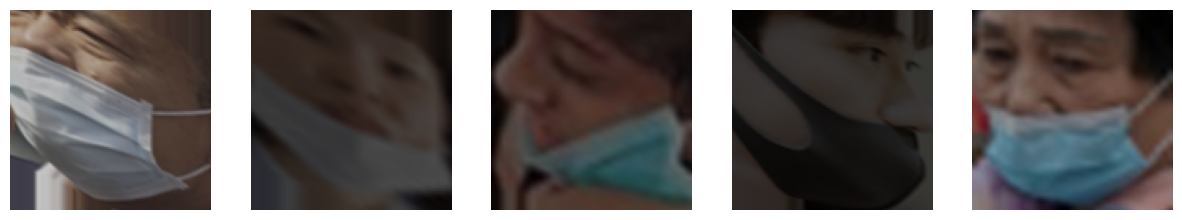

In [ ]:
view_images(class_name="mask_weared_incorrect")

In [ ]:
# Rescaling the images into tensors and creating batches

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_gen = ImageDataGenerator(rescale=1./255)

train_data = data_gen.flow_from_directory(directory=train_dir,
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode="categorical")

val_data = data_gen.flow_from_directory(directory=test_dir,
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode="categorical")

Found 7200 images belonging to 3 classes.
Found 1782 images belonging to 3 classes.


## Building a CNN model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10,3,activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3,activation='softmax'),
])

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [ ]:
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/5
225/225 [==============================] - 38s 105ms/step - loss: 0.8375 - accuracy: 0.6256 - val_loss: 0.4722 - val_accuracy: 0.8232
Epoch 2/5
225/225 [==============================] - 22s 96ms/step - loss: 0.4102 - accuracy: 0.8482 - val_loss: 0.5859 - val_accuracy: 0.8081
Epoch 3/5
225/225 [==============================] - 17s 77ms/step - loss: 0.3494 - accuracy: 0.8732 - val_loss: 0.2660 - val_accuracy: 0.9001
Epoch 4/5
225/225 [==============================] - 23s 101ms/step - loss: 0.2944 - accuracy: 0.8926 - val_loss: 0.2522 - val_accuracy: 0.9119
Epoch 5/5
225/225 [==============================] - 19s 83ms/step - loss: 0.3450 - accuracy: 0.8839 - val_loss: 0.2681 - val_accuracy: 0.9024


In [ ]:
# Function for plotting loss curve

def loss_curve(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label="Training_Loss")
  plt.plot(epochs, val_loss, label="Val_Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="Training_Accuracy1")
  plt.plot(epochs, val_accuracy, label="Val_Accuracy")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

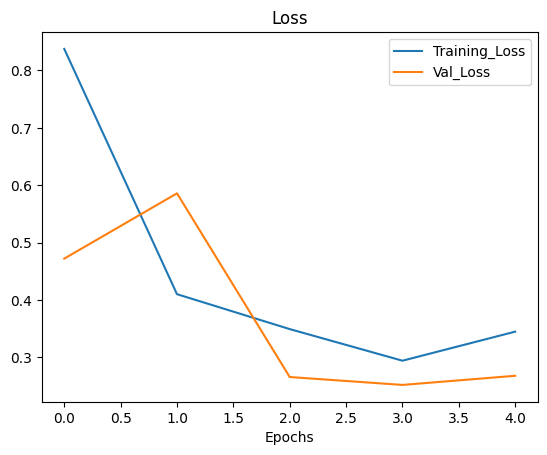

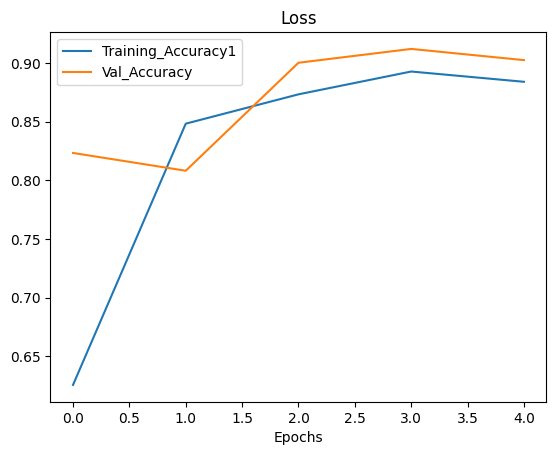

In [ ]:
loss_curve(history)

### Improving the model:
> Data Augmentation

In [ ]:
datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

aug_train_data = datagen_aug.flow_from_directory(directory=train_dir,
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode="categorical")

Found 7200 images belonging to 3 classes.


In [ ]:
# Clonning the old model

new_model = tf.keras.models.clone_model(model)

new_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [ ]:
new_history = new_model.fit(aug_train_data,
                            epochs=5,
                            steps_per_epoch=len(aug_train_data),
                            validation_data=val_data,
                            validation_steps=len(val_data))

Epoch 1/5
225/225 [==============================] - 110s 482ms/step - loss: 0.5544 - accuracy: 0.7657 - val_loss: 0.3664 - val_accuracy: 0.8625
Epoch 2/5
225/225 [==============================] - 119s 528ms/step - loss: 0.4353 - accuracy: 0.8304 - val_loss: 0.3021 - val_accuracy: 0.8878
Epoch 3/5
225/225 [==============================] - 104s 462ms/step - loss: 0.3990 - accuracy: 0.8451 - val_loss: 0.2935 - val_accuracy: 0.8878
Epoch 4/5
225/225 [==============================] - 94s 419ms/step - loss: 0.3819 - accuracy: 0.8510 - val_loss: 0.2783 - val_accuracy: 0.8956
Epoch 5/5
225/225 [==============================] - 95s 421ms/step - loss: 0.3702 - accuracy: 0.8531 - val_loss: 0.2763 - val_accuracy: 0.8945


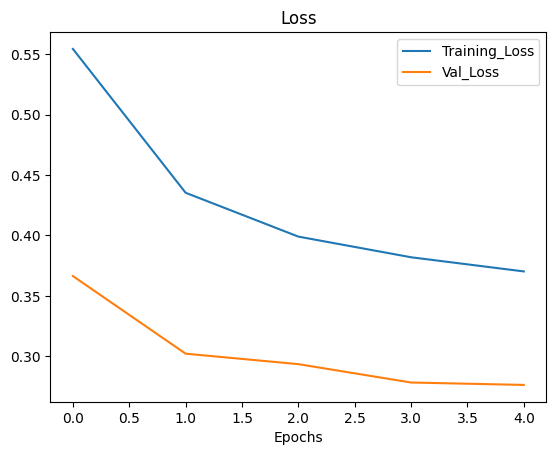

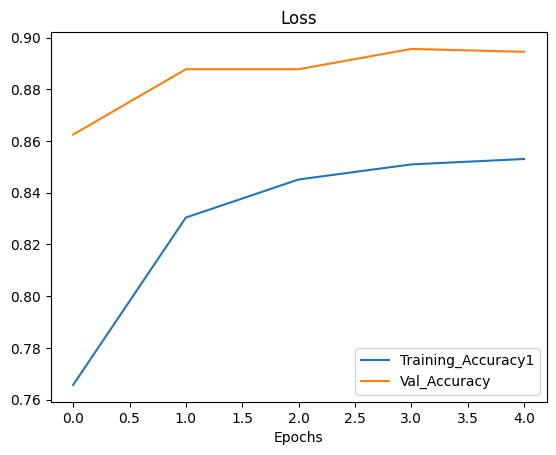

In [ ]:
loss_curve(new_history)

## Making Predictions

In [ ]:
img_shape = 224

def preprocess_img_to_classname(model, filename, IMG_SHAPE=img_shape):
  '''
    This function decodes the images into tensors, resizes, rescales and
    get's the highest probablity from the tensor and that index will be matched
    with the className's index and that className is shown as prediction. Enter
    model_name, image_name and default img_shape=224.
  '''

  # Read image
  image = tf.io.read_file(filename)

  # Decode into tensors
  image = tf.image.decode_image(image)

  # Resize
  image = tf.image.resize(image, size=[IMG_SHAPE, IMG_SHAPE])

  # Rescale
  image = image/255.

  # Expanding dims
  image = tf.expand_dims(image, axis=0)

  # Prediction
  preds = model.predict(image)

  # ClassName
  name = class_name[tf.argmax(preds[0])]
  return name

In [ ]:
# Downloading random images for predictions

!wget https://assets-prd.ignimgs.com/2023/07/06/mk1-scorpion-br-1688664595384.png
!wget https://cdn.britannica.com/11/222411-050-D3D66895/American-politician-actor-athlete-Arnold-Schwarzenegger-2016.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/8/84/Sylvester_Stallone_Cannes_2019.jpg
!wget https://img.freepik.com/premium-photo/young-woman-warm-winter-clothing-wearing-pink-disposable-virus-face-mask-incorrect-her-nose-covered_692357-7067.jpg?w=2000

--2023-08-10 12:01:21--  https://assets-prd.ignimgs.com/2023/07/06/mk1-scorpion-br-1688664595384.png
Resolving assets-prd.ignimgs.com (assets-prd.ignimgs.com)... 151.101.1.135, 151.101.65.135, 151.101.129.135, ...
Connecting to assets-prd.ignimgs.com (assets-prd.ignimgs.com)|151.101.1.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1102671 (1.1M) [image/png]
Saving to: ‘mk1-scorpion-br-1688664595384.png.3’

mk1-scorpion-br-168 100%[===================>]   1.05M  --.-KB/s    in 0.05s   

2023-08-10 12:01:21 (20.0 MB/s) - ‘mk1-scorpion-br-1688664595384.png.3’ saved [1102671/1102671]

--2023-08-10 12:01:21--  https://cdn.britannica.com/11/222411-050-D3D66895/American-politician-actor-athlete-Arnold-Schwarzenegger-2016.jpg
Resolving cdn.britannica.com (cdn.britannica.com)... 13.249.85.94, 13.249.85.122, 13.249.85.15, ...
Connecting to cdn.britannica.com (cdn.britannica.com)|13.249.85.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [ ]:
mask_img = "/content/mk1-scorpion-br-1688664595384.png.3"
without_mask_img = "/content/American-politician-actor-athlete-Arnold-Schwarzenegger-2016.jpg.1"
wrong_mask_img = "/content/young-woman-warm-winter-clothing-wearing-pink-disposable-virus-face-mask-incorrect-her-nose-covered_692357-7067.jpg?w=2000"
SS = "/content/Sylvester_Stallone_Cannes_2019.jpg"

### Predictions of [old_model, new_model]

1/1 [==============================] - 0s 19ms/step


Text(0.5, 1.0, "['mask_weared_incorrect', 'with_mask']")

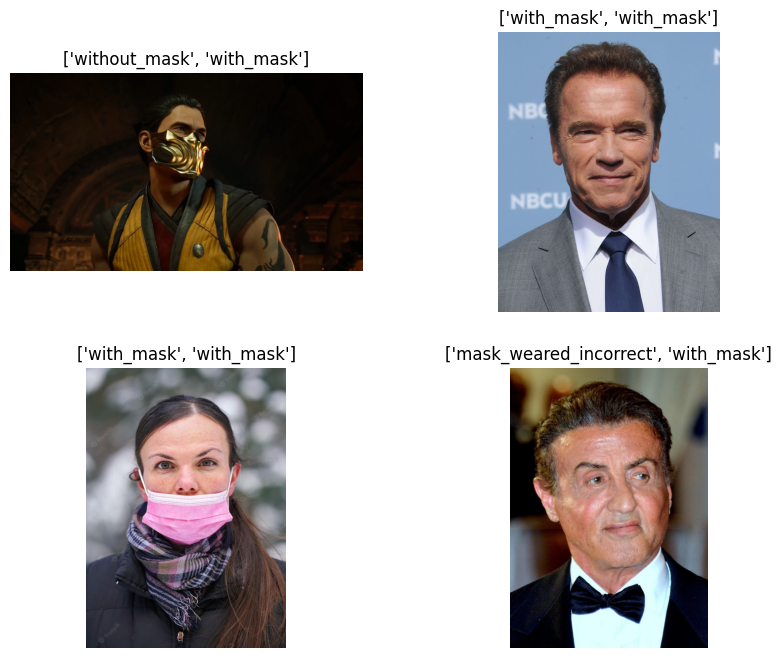

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

img1 = mpimg.imread(mask_img)
ax[0,0].imshow(img1)
ax[0,0].axis("off")
ax[0,0].set_title([preprocess_img_to_classname(model, mask_img), preprocess_img_to_classname(new_model, mask_img)])

img2 = mpimg.imread(without_mask_img)
ax[0,1].imshow(img2)
ax[0,1].axis("off")
ax[0,1].set_title([preprocess_img_to_classname(model, without_mask_img), preprocess_img_to_classname(new_model, without_mask_img)])


img3 = mpimg.imread(wrong_mask_img)
ax[1,0].imshow(img3)
ax[1,0].axis("off")
ax[1,0].set_title([preprocess_img_to_classname(model, wrong_mask_img), preprocess_img_to_classname(new_model, wrong_mask_img)])


img4 = mpimg.imread(SS)
ax[1,1].imshow(img4)
ax[1,1].axis("off")
ax[1,1].set_title([preprocess_img_to_classname(model, SS), preprocess_img_to_classname(new_model, SS)])


## Imporving Predictions by using:
> Transfer Learning ('EfficientNet')

In [ ]:
import tensorflow_hub as hub

INPUT_SHAPE = [None, 224, 224, 3]

OUTPUT_SHAPE = len(class_name)

MODEL_URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
model_layers = hub.KerasLayer(MODEL_URL, trainable=False)

trans_model = tf.keras.Sequential([
    model_layers,
    tf.keras.layers.Dense(OUTPUT_SHAPE, activation='softmax', )
])

trans_model.build(INPUT_SHAPE)

trans_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dense_2 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 5,923,155
Trainable params: 3,843
Non-trainable params: 5,919,312
_________________________________________________________________


In [ ]:
trans_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

trans_history = trans_model.fit(aug_train_data,
                    epochs=5,
                    steps_per_epoch=len(aug_train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/5
225/225 [==============================] - 123s 505ms/step - loss: 0.3461 - accuracy: 0.8740 - val_loss: 0.2101 - val_accuracy: 0.9203
Epoch 2/5
225/225 [==============================] - 96s 426ms/step - loss: 0.2155 - accuracy: 0.9221 - val_loss: 0.1622 - val_accuracy: 0.9371
Epoch 3/5
225/225 [==============================] - 97s 429ms/step - loss: 0.1869 - accuracy: 0.9322 - val_loss: 0.1391 - val_accuracy: 0.9495
Epoch 4/5
225/225 [==============================] - 97s 431ms/step - loss: 0.1610 - accuracy: 0.9446 - val_loss: 0.1226 - val_accuracy: 0.9596
Epoch 5/5
225/225 [==============================] - 97s 430ms/step - loss: 0.1463 - accuracy: 0.9482 - val_loss: 0.1122 - val_accuracy: 0.9596


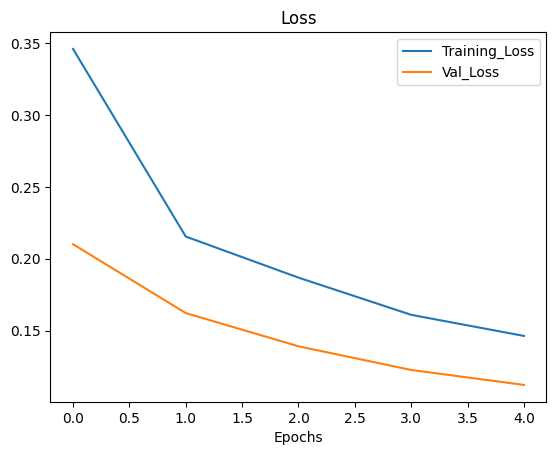

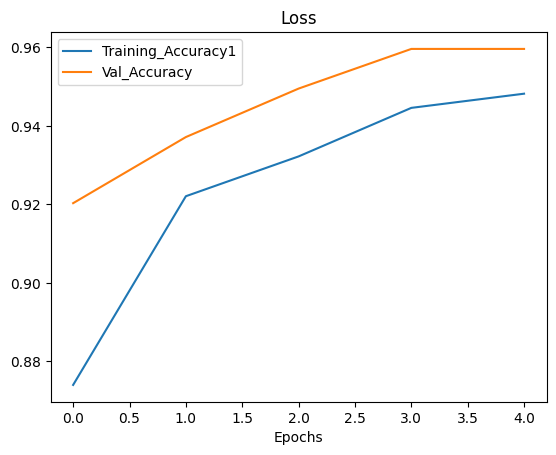

In [ ]:
loss_curve(trans_history)

## Making prediction using the **EfficientNet** model

1/1 [==============================] - 0s 26ms/step


Text(0.5, 1.0, 'without_mask')

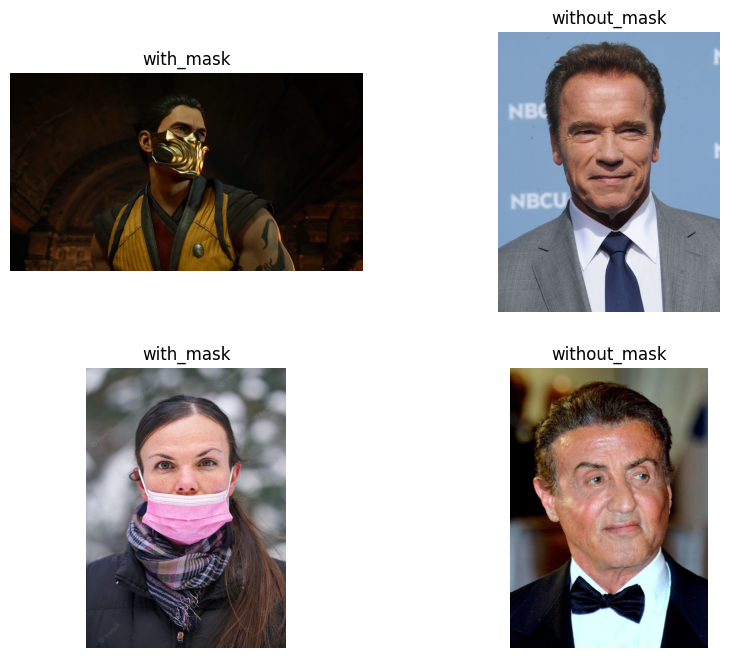

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

img1 = mpimg.imread(mask_img)
ax[0,0].imshow(img1)
ax[0,0].axis("off")
ax[0,0].set_title(preprocess_img_to_classname(trans_model, mask_img))

img2 = mpimg.imread(without_mask_img)
ax[0,1].imshow(img2)
ax[0,1].axis("off")
ax[0,1].set_title(preprocess_img_to_classname(trans_model, without_mask_img))

img3 = mpimg.imread(wrong_mask_img)
ax[1,0].imshow(img3)
ax[1,0].axis("off")
ax[1,0].set_title(preprocess_img_to_classname(trans_model, wrong_mask_img))

img4 = mpimg.imread(SS)
ax[1,1].imshow(img4)
ax[1,1].axis("off")
ax[1,1].set_title(preprocess_img_to_classname(trans_model, SS))

## Saving the model and Weights

In [ ]:
eff_net_model = trans_model.save('mask_detection_model.h5')

In [73]:
eff_net_weights = trans_model.save_weights('mask_detection_weights.h5')